#Abstractive Summary

In [1]:

import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import *
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not",

    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not",

    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is",

    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",

    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would",

    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam",

    "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
    "must've": "must have",

    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock",

    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have",

    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is",

    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as",

    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would",

    "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have",

    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have",

    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are",

    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are",

    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is",

    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have",

    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have",

    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

In [4]:
class DataPreprocessor:
    def __init__(self, max_text_len=100, max_summary_len=15):
        self.max_text_len = max_text_len
        self.max_summary_len = max_summary_len
        self.x_tokenizer = None
        self.y_tokenizer = None
        # self.data = None

    def load_csv_from_google_drive(self, url, name):
        # Attempting to load a CSV file from a Google Drive link into a Pandas DataFrame.
        try:
            # Extracting file ID from the original URL to construct a direct download link.
            url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

            # Loading the CSV data from the constructed URL into a Pandas DataFrame.
            df = pd.read_csv(url, encoding='iso-8859-1')

            # Confirmation message upon successful loading of CSV data.
            print(f'{name} CSV loaded successfully.')

            # Returning the loaded DataFrame.
            return df

        except Exception as e:
            # Handling any exceptions that may occur during the process and printing the error message.
            print('Exception occurred: ', e)

    def load_data(self, ):
        print('Loading the summary dataset...')
        summary_df = self.load_csv_from_google_drive(
            "https://drive.google.com/file/d/1jjjtai8R0BTfTtfucbOQPCJTllXfV9Dy/view?usp=sharing", "Summary")

        print('\nLoading the raw dataset...')
        raw_df = self.load_csv_from_google_drive(
            "https://drive.google.com/file/d/1pt4kBnL0i-qtBKwgxBeTTKnkGINq8miE/view?usp=sharing", "Raw")

        # preprocessing steps
        raw_df_copy = raw_df.iloc[:, 0:2].copy()
        summary_df_copy = summary_df.iloc[:, 0:6].copy()
        summary_df_copy['text'] = summary_df_copy['author'].str.cat(summary_df_copy['date'].str.cat(
            summary_df_copy['read_more'].str.cat(summary_df_copy['text'].str.cat(summary_df_copy['ctext'], sep=" "),
                                                 sep=" "), sep=" "), sep=" ")

        data = pd.DataFrame()
        data['text'] = pd.concat([raw_df_copy['text'], summary_df_copy['text']], ignore_index=True)
        data['summary'] = pd.concat([raw_df_copy['headlines'], summary_df_copy['headlines']], ignore_index=True)

        self.data = data
        return self.data

    def replace_contractions(self, text):
        def replace(match):
            return contraction_mapping[match.group(0)]

        return re.sub("|".join(contraction_mapping.keys()), replace, text)

    def clean_text(self, _column):
        for row in _column:
            row = re.sub("(\\t)", ' ', str(row)).lower()  #remove escape charecters
            row = re.sub("(\\r)", ' ', str(row)).lower()
            row = re.sub("(\\n)", ' ', str(row)).lower()

            row = re.sub("(__+)", ' ', str(row)).lower()  #remove _ if it occors more than one time consecutively
            row = re.sub("(--+)", ' ', str(row)).lower()  #remove - if it occors more than one time consecutively
            row = re.sub("(~~+)", ' ', str(row)).lower()  #remove ~ if it occors more than one time consecutively
            row = re.sub("(\+\++)", ' ', str(row)).lower()  #remove + if it occors more than one time consecutively
            row = re.sub("(\.\.+)", ' ', str(row)).lower()  #remove . if it occors more than one time consecutively

            row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()  #remove <>()|&©ø"',;?~*!

            row = re.sub("(mailto:)", ' ', str(row)).lower()  #remove mailto:
            row = re.sub(r"(\\x9\d)", ' ', str(row)).lower()  #remove \x9* in text
            row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower()  #replace INC nums to INC_NUM
            row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower()  #replace CM# and CHG# to CM_NUM

            row = re.sub("(\.\s+)", ' ', str(row)).lower()  #remove full stop at end of words(not between)
            row = re.sub("(\-\s+)", ' ', str(row)).lower()  #remove - at end of words(not between)
            row = re.sub("(\:\s+)", ' ', str(row)).lower()  #remove : at end of words(not between)

            row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  #remove any single charecters hanging between 2 spaces

            #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
            try:
                url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
                repl_url = url.group(3)
                row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(row))
            except Exception:
                pass  #there might be emails with no url in them

            row = re.sub("(\s+)", ' ', str(row)).lower()  #remove multiple spaces

            yield re.sub("(\s+.\s+)", ' ', str(row)).lower()

    def split_data(self, data):
        x_train, x_val, y_train, y_val = train_test_split(data['text'], data['summary'], test_size=0.1, random_state=0,
                                                          shuffle=True)
        return x_train, x_val, y_train, y_val

In [5]:
preprocessor = DataPreprocessor()
df = preprocessor.load_data()

Loading the summary dataset...
Summary CSV loaded successfully.

Loading the raw dataset...
Raw CSV loaded successfully.


In [6]:
df.columns

Index(['text', 'summary'], dtype='object')

### Data Exploration

In [7]:
df.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED


In [8]:
df['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...
1    Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...
2    New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3    With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...
4    Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement w

In [9]:
df['text'] = df['text'].apply(str).apply(preprocessor.replace_contractions)
df['summary'] = df['summary'].apply(str).apply(preprocessor.replace_contractions)

In [10]:
text_data = preprocessor.clean_text(df['text'])
summary_data = preprocessor.clean_text(df['summary'])

In [11]:
# from time import time
# import spacy

# # disabling Named Entity Recognition for speed
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# t = time()

# # Batch the data points into 5000 and run on all cores for faster preprocessing
# text_column = [str(doc) for doc in nlp.pipe(text_data, batch_size=5000, n_process=-1)]

# # Takes 7-8 mins
# print(f'Time to clean up everything: {round((time() - t) / 60, 2)} mins')

In [12]:
# #Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


# t = time()

# # Batch the data points into 5000 and run on all cores for faster preprocessing
# summary_column = [
#     f'_START_ {str(doc)} _END_'
#     for doc in nlp.pipe(summary_data, batch_size=5000, n_process=-1)
# ]

# print(f'Time to clean up everything: {round((time() - t) / 60, 2)} mins')

In [13]:
# text_column[0]

In [14]:
# summary_column[0]

In [15]:
df['cleaned_text'] = pd.Series(text_data)
df['cleaned_summary'] = pd.Series(summary_data)

In [16]:
df.head()

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,upgrad learner switches to career in ml al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,delhi techie wins free food from swiggy for one year on cred
2,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,New Zealand end Rohit Sharma-led India's 12-match winning streak,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,new zealand end rohit sharma-led india 12-match winning streak
3,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",Aegon life iTerm insurance plan helps customers save tax,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,aegon life iterm insurance plan helps customers save tax
4,"Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I have known Hirani for many years...What if it is not true, the [#MeToo] movement will get derailed.""...","Have known Hirani for yrs, what if MeToo claims are not true: Sonam",speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,have known hirani for yrs what if metoo claims are not true sonam


In [17]:
# df.to_csv('./cleaned_summary.csv')

In [18]:
# Select the Summaries and Text between max_len defined above

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary = np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (len(cleaned_summary[i].split()) <= preprocessor.max_summary_len and len(
            cleaned_text[i].split()) <= preprocessor.max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

new_df = pd.DataFrame({
    'text': short_text,
    'summary': short_summary
})

In [19]:
new_df.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,upgrad learner switches to career in ml al with 90% salary hike
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,delhi techie wins free food from swiggy for one year on cred
2,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,new zealand end rohit sharma-led india 12-match winning streak
3,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,aegon life iterm insurance plan helps customers save tax
4,speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,have known hirani for yrs what if metoo claims are not true sonam


In [20]:
# Add sostok and eostok at 
new_df['summary'] = new_df['summary'].apply(lambda x: f'sostok {x} eostok')

In [21]:
new_df.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,sostok upgrad learner switches to career in ml al with 90% salary hike eostok
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,sostok delhi techie wins free food from swiggy for one year on cred eostok
2,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,sostok new zealand end rohit sharma-led india 12-match winning streak eostok
3,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,sostok aegon life iterm insurance plan helps customers save tax eostok
4,speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,sostok have known hirani for yrs what if metoo claims are not true sonam eostok


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [22]:
x_tr, x_val, y_tr, y_val = preprocessor.split_data(new_df)

print(f'x_tr.shape: {x_tr.shape[0]}')
print(f'y_tr.shape: {y_tr.shape[0]}')
print(f'x_val.shape: {x_val.shape[0]}')
print(f'y_val.shape: {y_val.shape[0]}')

x_tr.shape: 88715
y_tr.shape: 88715
x_val.shape: 9858
y_val.shape: 9858


In [23]:
# Lets tokenize the text to get the vocab count

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [24]:
def find_text_frequency_count(tokenized_text, threshold):
    # Initialize count and frequency for words below the threshold
    count = 0
    frequency = 0

    # Calculate total count of words and their total frequency
    total_count = len(tokenized_text.word_counts)
    total_frequency = 0

    # Iterate through the word counts
    for value in tokenized_text.word_counts.values():
        total_frequency += value

        # Check if the word count is below the threshold
        if value < threshold:
            count += 1
            frequency += value

    # Return the results
    return count, total_count, frequency, total_frequency

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
count, total_count, frequency, total_frequency = find_text_frequency_count(x_tokenizer, 4)

print(f"Rare vocabulary words in train dataset: {round((count / total_count) * 100, 2)}%")
print(f"Rare words total Coverage in train dataset: {round((frequency / total_frequency) * 100, 2)}")

Rare vocabulary words in train dataset: 57.91%
Rare words total Coverage in train dataset: 1.34


In [27]:
count, total_count, frequency, total_frequency

(45958, 79357, 68802, 5153577)

In [28]:
def tokenize_text(_train, _validate, num_words):
    # prepare a tokenizer for reviews on training data
    _tokenizer = Tokenizer(num_words=num_words)
    _tokenizer.fit_on_texts(list(_train))

    # convert text sequences into integer sequences
    _train_seq = _tokenizer.texts_to_sequences(_train)
    _validate_seq = _tokenizer.texts_to_sequences(_validate)

    # padding zero upto maximum length
    _train = pad_sequences(
        _train_seq, maxlen=preprocessor.max_text_len, padding='post')
    _validate = pad_sequences(
        _validate_seq, maxlen=preprocessor.max_text_len, padding='post')

    vocab_size = len(_tokenizer.word_index) + 1

    return _train, _validate, vocab_size, _tokenizer

In [29]:
# prepare a tokenizer for reviews on training data
x_train, x_validate, x_vocab_size, x_tokenizer = tokenize_text(x_tr, x_val, total_count - count)

print(f"X vocabulary size is: {x_vocab_size}")

X vocabulary size is: 79358


In [30]:
count, total_count, frequency, total_frequency = find_text_frequency_count(y_tokenizer, threshold=6)

print(f"Rare vocabulary words in test dataset: {round((count / total_count) * 100, 2)}%")
print(f"Rare words total Coverage in test dataset: {round((frequency / total_frequency) * 100, 2)}")

Rare vocabulary words in test dataset: 66.36%
Rare words total Coverage in test dataset: 4.16


In [31]:
count, total_count, frequency, total_frequency

(22846, 34425, 43150, 1037704)

In [32]:
# prepare a tokenizer for summary on training data
y_train, y_validate, y_vocab_size, y_tokenizer = tokenize_text(y_tr, y_val, total_count - count)

print(f"Y vocabulary size is: {y_vocab_size}")

Y vocabulary size is: 34426


In [33]:
def remove_summary(_x_data, _y_data):
    # Create a boolean mask for rows with exactly two non-zero elements
    mask = np.array([np.count_nonzero(row) != 2 for row in _y_data])

    # Use the mask to filter out the rows
    _x_data = _x_data[mask]
    _y_data = _y_data[mask]

    return _x_data, _y_data

In [34]:
x_train, y_train = remove_summary(x_train, y_train)
x_validate, y_validate = remove_summary(x_validate, y_validate)

In [56]:
class Seq2SeqModel:
    def __init__(self, ):
        self.latent_dim = 128
        self.embedding_dim = 128
        self.batch_size = 64
        self.epochs = 15  # change to higher number 8 50
        self.model = None
        self.encoder_model = None
        self.decoder_model = None
        self.max_text_len = 100
        self.max_summary_len = 15

        self.encoder_inputs = None
        self.encoder_outputs = None
        self.decoder_inputs = None
        self.decoder_outputs = None
        self.dec_emb_layer = None
        self.decoder_lstm = None
        self.decoder_dense = None
        self.state_h = None
        self.state_c = None

    def create_model(self, x_vocab_size, y_vocab_size):
        # Encoder
        self.encoder_inputs = Input(shape=(self.max_text_len,))

        # embedding layer
        enc_emb_layer = Embedding(x_vocab_size, self.embedding_dim, trainable=True)(self.encoder_inputs)

        # encoder lstm 1
        encoder_lstm1 = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4)  #,
        #recurrent_dropout=0.4)
        encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb_layer)

        # encoder lstm 2
        encoder_lstm2 = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4)  #,
        #recurrent_dropout=0.4)
        encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

        # encoder lstm 3
        encoder_lstm3 = LSTM(self.latent_dim, return_state=True, return_sequences=True, dropout=0.4)  #,
        #recurrent_dropout=0.4)
        self.encoder_outputs, self.state_h, self.state_c = encoder_lstm3(encoder_output2)

        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,))

        # embedding layer
        self.dec_emb_layer = Embedding(y_vocab_size, self.embedding_dim, trainable=True)
        dec_emb = self.dec_emb_layer(self.decoder_inputs)

        self.decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4)  #,
        #recurrent_dropout=0.2)
        self.decoder_outputs, decoder_fwd_state, decoder_back_state = self.decoder_lstm(dec_emb,
                                                                                        initial_state=[self.state_h,
                                                                                                       self.state_c])

        # dense layer
        self.decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model 
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                           loss='sparse_categorical_crossentropy')
        #'rmsprop'

        self.get_model_summary()

        return self.model

    def encode_decoder(self, ):
        # Encode the input sequence to get the feature vector
        self.encoder_model = Model(inputs=self.encoder_inputs,
                                   outputs=[self.encoder_outputs, self.state_h, self.state_c])

        # Decoder setup
        # Below tensors will hold the states of the previous time step
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_hidden_state_input = Input(shape=(self.max_text_len, self.latent_dim))

        # Get the embeddings of the decoder sequence
        dec_emb2 = self.dec_emb_layer(self.decoder_inputs)

        # To predict the next word in the sequence, set the initial states to the states from the previous time step
        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h,
                                                                                          decoder_state_input_c])

        # A dense softmax layer to generate prob dist. over the target vocabulary
        decoder_outputs2 = self.decoder_dense(decoder_outputs2)

        # Final decoder model
        self.decoder_model = Model(
            [self.decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
            [decoder_outputs2] + [state_h2, state_c2]
        )

    def decode_sequence(self, input_seq, target_word_index, reverse_target_word_index):
        # Encode the input as state vectors.
        e_out, e_h, e_c = self.encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1))

        # Populate the first word of target sequence with the start word.
        target_seq[0, 0] = target_word_index['sostok']

        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + [e_out, e_h, e_c])

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_word_index[sampled_token_index]

            if (sampled_token != 'eostok'):
                decoded_sentence += f' {sampled_token}'

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (preprocessor.max_summary_len - 1)):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            e_h, e_c = h, c

        return decoded_sentence

    def generate_summary(self, input_seq, target_word_index, reverse_target_word_index):
        return ' '.join([reverse_target_word_index[i] for i in input_seq if
                         i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']])

    def generate_text(self, input_seq, reverse_source_word_index):
        return ' '.join([reverse_source_word_index[i] for i in input_seq if i != 0])

    def get_model_summary(self):
        return self.model.summary()

    def plot(self, history):
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

    def save_model(self):
        self.model.save('sequence_2_sequence.keras')
        self.encoder_model.save('encoder_model.keras')
        self.decoder_model.save('decoder_model.keras')
        print('Model saved successfully...')

    def train_model(self, _x_train, _y_train, _x_validate, _y_validate):
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

        return self.model.fit(
            [_x_train, _y_train[:, :-1]],
            _y_train.reshape(_y_train.shape[0], _y_train.shape[1], 1)[:, 1:],
            epochs=self.epochs,
            callbacks=[es],
            batch_size=self.batch_size,
            validation_data=(
                [_x_validate, _y_validate[:, :-1]],
                _y_validate.reshape(_y_validate.shape[0], _y_validate.shape[1], 1)[:, 1:]
            )
        )


In [57]:
s2s_model = Seq2SeqModel()

model = s2s_model.create_model(x_vocab_size, y_vocab_size)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 100, 128)     10157824    ['input_9[0][0]']                
                                                                                                  
 lstm_16 (LSTM)                 [(None, 100, 128),   131584      ['embedding_8[0][0]']            
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [58]:
#Check that tensorflow is recognizing the GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Start training the model with the data**

In [59]:
history = s2s_model.train_model(x_train, y_train, x_validate, y_validate)

Epoch 1/15
1387/1387 [==============================] - 393s 279ms/step - loss: 2.1724 - val_loss: 0.7394
Epoch 2/15
1387/1387 [==============================] - 392s 282ms/step - loss: 0.7376 - val_loss: 0.7274
Epoch 3/15
1387/1387 [==============================] - 389s 280ms/step - loss: 0.7285 - val_loss: 0.7202
Epoch 4/15
1387/1387 [==============================] - 388s 280ms/step - loss: 0.7209 - val_loss: 0.7148
Epoch 5/15
1387/1387 [==============================] - 388s 280ms/step - loss: 0.7130 - val_loss: 0.7055
Epoch 6/15
1387/1387 [==============================] - 389s 280ms/step - loss: 0.7058 - val_loss: 0.6990
Epoch 7/15
1387/1387 [==============================] - 388s 280ms/step - loss: 0.6990 - val_loss: 0.6923
Epoch 8/15
1387/1387 [==============================] - 392s 282ms/step - loss: 0.6919 - val_loss: 0.6857
Epoch 9/15
1387/1387 [==============================] - 389s 281ms/step - loss: 0.6856 - val_loss: 0.6811
Epoch 10/15
1387/1387 [=======================

**Visualize the model learning**

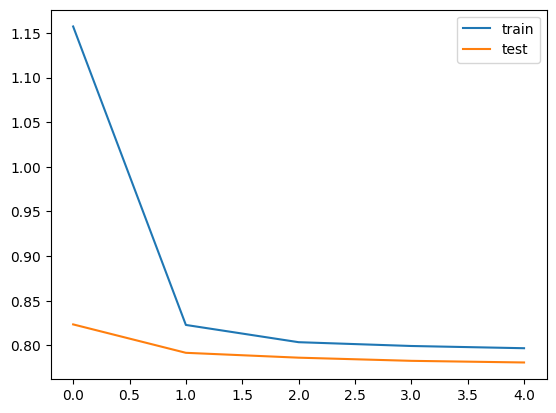

In [154]:
#plot of model at 5 epoch, latent_dim = 300, embedding_dim = 200, batch_size = 256
s2s_model.plot(history)

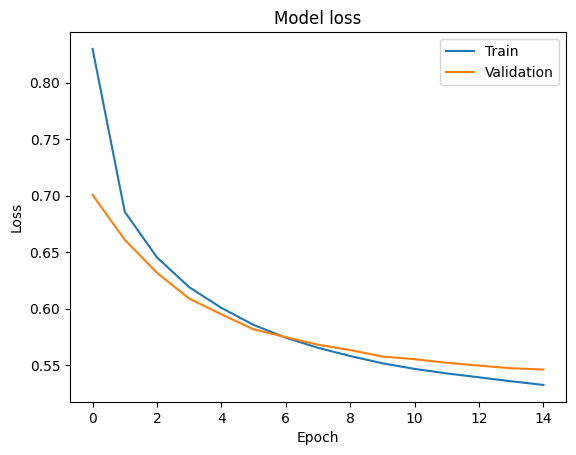

In [55]:
#Run 2
#plot of model at 15 epoch, latent_dim = 128, embedding_dim = 128, batch_size = 64,patience=2, removed recurrent_dropout=0.2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

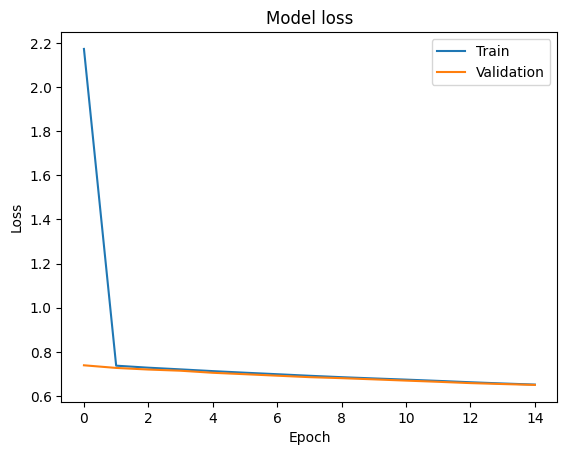

In [60]:
#Run 3
#plot of model at 15 epoch, latent_dim = 128, embedding_dim = 128, batch_size = 64,patience=4, removed recurrent_dropout=0.2, 
#included learning rate = 0.0001
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [61]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [62]:
s2s_model.encode_decoder()

In [63]:
s2s_model.save_model()

Model saved successfully...


In [64]:
model_components = {
    'x_tokenizer': x_tokenizer,
    'y_tokenizer': y_tokenizer,
    'reverse_source_word_index': reverse_source_word_index,
    'reverse_target_word_index': reverse_target_word_index,
    'target_word_index': target_word_index,
    'max_text_len': preprocessor.max_text_len,
    'max_summary_len': preprocessor.max_summary_len
}

with open('model_components.pkl', 'wb') as f:
    pickle.dump(model_components, f)
    print('Model components saved successfully...')

Model components saved successfully...


**Run the model over the data to see the results**

In [104]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
original_summary = []
predicted_summary = []
for i in range(1, 10):
    #print("Review:", s2s_model.generate_text(x_train[i], reverse_source_word_index))
    original_summary.append(s2s_model.generate_summary(y_train[i], target_word_index, reverse_target_word_index))
    predicted_summary.append(
        s2s_model.decode_sequence(x_train[i].reshape(1, preprocessor.max_text_len), target_word_index,
                                  reverse_target_word_index))

    #to facilitate generating the rouge scores
    original = s2s_model.generate_summary(y_train[i], target_word_index, reverse_target_word_index)
    predicted = s2s_model.decode_sequence(x_train[i].reshape(1, preprocessor.max_text_len), target_word_index,
                                          reverse_target_word_index)
    print("\n")

    # Print summaries for verification
    #print("Original summary:", original)
    #print("Predicted summary:", predicted)
    #print("\n")

    # Calculate ROUGE-1, ROUGE-2 and ROUGE-L 
    r_scores = scorer.score(original, predicted)
    rouge_scores['rouge1'].append(r_scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(r_scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(r_scores['rougeL'].fmeasure)

# Calculate the average ROUGE scores
rouge1_mean = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
rouge2_mean = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
rougeL_mean = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])



1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step




In [105]:
#create two dataframes 1) Dataframe with original summary and predicted summary 2) with calculated rouge socres
rouge_scores_table = pd.DataFrame(list(zip(original_summary, predicted_summary)),
                                  columns=['original_summary', 'predicted_summary'])
rouge_table = pd.DataFrame(rouge_scores)

#create a final dataframe with both results combined
results_table = pd.concat([rouge_scores_table, rouge_table], ignore_index=True, axis=1)
results_table.rename(columns={0: 'original_summary', 1: 'predicted_summary', 2: 'ROUGE-1', 3: 'ROUGE-2', 4: 'ROUGE-L'},
                     inplace=True)

#display the results
results_table

,original_summary,predicted_summary,ROUGE-1,ROUGE-2,ROUGE-L
0,sunny leone announces birth of twin boys,i am the the the the the the time of time,0.111111,0.0,0.111111
1,water rich diamonds of oceans deep inside earth,scientists to be in the first time,0.000000,0.0,0.000000
2,will pay legal fees to defend employees microsoft,india to be to be to be in india,0.117647,0.0,0.117647
3,evms to display candidates pictures in rajasthan bypoll,i am not not not be in india in india,0.111111,0.0,0.111111
4,not black day over emergency to criticise cong pm,pm modi to be to be for pm modi,0.222222,0.0,0.222222
5,rahul did not act on my sexual abuse complaint ex cong worker,pm modi to be to be in pm modi,0.000000,0.0,0.000000
6,iit iim graduate found hanging from ceiling in gurugram flat,man to be in mumbai in mumbai,0.117647,0.0,0.117647
7,longest wedding dress train is 27 times eiffel tower size,man to be in the world world,0.000000,0.0,0.000000
8,cricketer and junior champ chahal beats nz player at chess,india to be in india in india,0.000000,0.0,0.000000


In [107]:
#Show mean Rouge Scores in tabular format
mean_rouge_scores = {'ROUGE-1': [rouge1_mean.round(2)], 'ROUGE-2': [rouge2_mean.round(2)],
                     'ROUGE-L': [rougeL_mean.round(2)]}
rouge_scores_mean = pd.DataFrame(mean_rouge_scores)
rouge_scores_mean

,ROUGE-1,ROUGE-2,ROUGE-L
0,0.08,0.0,0.08


# Extractive Summary

In [8]:

from string import punctuation

import networkx as nx
import nltk
import spacy
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import re
from sentence_transformers import SentenceTransformer, util
import heapq
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
paragraph = '''
Pennsylvania Gov. Josh Shapiro said former President Donald Trump has left the Butler, Pennsylvania, area following the rally shooting Saturday.

“Under the protection of US Secret Service and with the assistance of the Pennsylvania State Police, former President Trump has now left the Butler area,” Shapiro said in a statement posted to X. “Lori and I are thankful that his team reports that he is fine and we continue to wish him a full and speedy recovery.”

“We mourn the loss of life and pray for the two victims who are being treated at this time,” he added. “I am grateful for all law enforcement who responded, protected the former president, and worked to bring the situation under control.”

Federal law enforcement officials will continue to lead on the investigation into the shooting, Shapiro said. Meanwhile, Pennsylvania State Police will lead the investigation into the shooting of the other victims. Shapiro said he has been communicating with law enforcement on the ground in Pennsylvania and has spoken with President Joe Biden, who “offered his full support.”

Shapiro said he knows “how painful and shocking this event is to so many of our fellow Pennsylvanians.” He asked “that we treat our fellow Americans with respect and join together to universally condemn the unacceptable violence we witnessed earlier today in Butler.”
'''

In [3]:
stop_words = set(stopwords.words('english') + list(punctuation))

In [4]:
def clean_text(text):
    text = text.strip()

    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # remove \n and quotes like “, ‘, ”
    text = re.sub(r'[\n“”‘’]', '', text)

    return text

### Extractive text summarization using word frequency

In [5]:
def summarize_text(text):
    text = clean_text(text)
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Tokenize the text into words and filter out stopwords and punctuation
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word not in stop_words]

    # Calculate word frequencies
    word_frequencies = {}
    for word in filtered_words:
        if word not in word_frequencies:
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

    # Calculate sentence scores
    sentence_scores = {}
    for sentence in sentences:
        for word in word_tokenize(sentence.lower()):
            if word in word_frequencies:
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = word_frequencies[word]
                else:
                    sentence_scores[sentence] += word_frequencies[word]

    # Get the top 30% of sentences with the highest scores
    summary_sentences = heapq.nlargest(int(len(sentences) * 0.3), sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    return summary


In [6]:
freq_summary = summarize_text(paragraph)
freq_summary

'Under the protection of US Secret Service and with the assistance of the Pennsylvania State Police, former President Trump has now left the Butler area, Shapiro said in a statement posted to X. Lori and I are thankful that his team reports that he is fine and we continue to wish him a full and speedy recovery. Josh Shapiro said former President Donald Trump has left the Butler, Pennsylvania, area following the rally shooting Saturday. Shapiro said he has been communicating with law enforcement on the ground in Pennsylvania and has spoken with President Joe Biden, who offered his full support.'

### Extractive text summarization using TF-IDF

In [7]:
def compute_tfidf_scores(text):
    vectorizer = TfidfVectorizer(stop_words=list(stop_words))
    vectors = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    # dense =
    dense_list = vectors.todense().tolist()
    tfidf_scores = dict(zip(feature_names, dense_list[0]))
    return tfidf_scores


def summarize_text_with_tfidf(text, summary_ratio=0.3):
    text = clean_text(text)
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return ""

    # Compute TF-IDF scores for words in the text
    tfidf_scores = compute_tfidf_scores(text)

    # Calculate sentence scores
    sentence_scores = {}
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        sentence_score = sum(tfidf_scores.get(word, 0) for word in words)
        sentence_scores[sentence] = sentence_score / len(words)  # Normalize by sentence length

    # Get the top `summary_ratio`% of sentences with the highest scores
    num_summary_sentences = max(1, int(len(sentences) * summary_ratio))
    summary_sentences = heapq.nlargest(num_summary_sentences, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    return summary

In [7]:
tfidf_summary = summarize_text_with_tfidf(paragraph)
tfidf_summary

'Pennsylvania Gov. Josh Shapiro said former President Donald Trump has left the Butler, Pennsylvania, area following the rally shooting Saturday. Federal law enforcement officials will continue to lead on the investigation into the shooting, Shapiro said.'

### Extractive text summarization using transformer

In [ ]:
%pip install rouge_score

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:



def compute_sentence_embeddings(sentences):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    return embeddings


def summarize_text_with_transformer(text, summary_ratio=0.3):
    text = clean_text(text)

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return ""

    # Compute sentence embeddings
    sentence_embeddings = compute_sentence_embeddings(sentences)

    # Compute pairwise sentence similarities
    sentence_scores = {}
    for i, sentence in enumerate(sentences):
        sentence_score = util.pytorch_cos_sim(sentence_embeddings[i], sentence_embeddings).sum().item()
        sentence_scores[sentence] = sentence_score / len(sentences)  # Normalize by number of sentences

    # Get the top `summary_ratio`% of sentences with the highest scores
    num_summary_sentences = max(1, int(len(sentences) * summary_ratio))
    summary_sentences = heapq.nlargest(num_summary_sentences, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    return summary

/Users/mac/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
transformer_summary = summarize_text_with_transformer(paragraph)
transformer_summary

### Extractive text summarization using NER

In [7]:
nlp = spacy.load('en_core_web_sm')


def score_with_ner(sentence, nlp_model):
    doc = nlp_model(sentence)
    return len([ent for ent in doc.ents])


def summarize_text_with_ner(text, summary_ratio=0.3):
    text = clean_text(text)

    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return ""

    sentence_embeddings = compute_sentence_embeddings(sentences)
    sentence_scores = {}

    for i, sentence in enumerate(sentences):
        ner_score = score_with_ner(sentence, nlp)
        sentence_score = util.pytorch_cos_sim(sentence_embeddings[i], sentence_embeddings).sum().item()
        sentence_scores[sentence] = (sentence_score + ner_score) / len(sentences)

    num_summary_sentences = max(1, int(len(sentences) * summary_ratio))
    summary_sentences = heapq.nlargest(num_summary_sentences, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    return summary


In [8]:
ner_summary = summarize_text_with_ner(paragraph)
ner_summary

NameError: name 'compute_sentence_embeddings' is not defined

### Extractive text summarization using TextRank

In [9]:
def summarize_text_with_textrank(text, summary_ratio=0.3):
    text = clean_text(text)

    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return ""

    # Compute sentence embeddings
    sentence_embeddings = model.encode(sentences)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(sentence_embeddings)

    # Build the similarity graph
    similarity_graph = nx.from_numpy_array(similarity_matrix)

    # Apply PageRank algorithm
    scores = nx.pagerank(similarity_graph)

    # Rank sentences by their scores
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Select the top `summary_ratio`% sentences
    num_summary_sentences = max(1, int(len(sentences) * summary_ratio))
    summary_sentences = [s for score, s in ranked_sentences[:num_summary_sentences]]
    summary = ' '.join(summary_sentences)
    return summary


In [10]:
textrank_summary = summarize_text_with_textrank(paragraph)
textrank_summary

NameError: name 'model' is not defined

### Extractive text summarization using redundancy removal

In [11]:
def redundancy_removal(selected_sentences, new_sentence, model, threshold=0.7):
    new_embedding = model.encode([new_sentence])[0]
    for sent in selected_sentences:
        sent_embedding = model.encode([sent])[0]
        if cosine_similarity([new_embedding], [sent_embedding])[0][0] > threshold:
            return False
    return True


def summarize_text_with_redundancy_removal(text, summary_ratio=0.3, redundancy_threshold=0.7):
    text = clean_text(text)

    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return ""

    sentence_embeddings = model.encode(sentences)
    similarity_matrix = cosine_similarity(sentence_embeddings)
    similarity_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(similarity_graph)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    num_summary_sentences = max(1, int(len(sentences) * summary_ratio))
    summary_sentences = []
    for score, sentence in ranked_sentences:
        if len(summary_sentences) < num_summary_sentences and redundancy_removal(summary_sentences, sentence, model,
                                                                                 redundancy_threshold):
            summary_sentences.append(sentence)

    summary = ' '.join(summary_sentences)
    return summary


In [12]:
redundancy_removal_summary = summarize_text_with_redundancy_removal(paragraph)
redundancy_removal_summary

NameError: name 'model' is not defined

### Extractive text summarization using Bert

In [ ]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")


def summarize_text_with_bert(text, summary_ratio=0.3):
    max_length = int(len(text.split()) * summary_ratio)
    min_length = max(5, int(max_length * 0.3))
    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text'].strip()

In [ ]:
bert_summary = summarize_text_with_bert(paragraph)
bert_summary

### Evaluation of the summaries

In [ ]:
def rouge_evaluate_summary(reference, summary) -> float:
    _scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return _scorer.score(reference, summary)


from nltk.translate.bleu_score import sentence_bleu


def blue_evaluate_summary(reference, summary):
    return sentence_bleu(reference, summary)
    # return sacrebleu.corpus_bleu(summary, [reference])


def evaluate_all_summaries(reference, summaries):
    evaluation_results = []
    for method, summary in summaries.items():
        _rouge_scores = rouge_evaluate_summary(reference, summary)

        evaluation_results.append({
            'method': method,
            'rouge1': round(_rouge_scores['rouge1'].fmeasure, 4),
            'rouge2': round(_rouge_scores['rouge2'].fmeasure, 4),
            'rougeL': round(_rouge_scores['rougeL'].fmeasure, 4),
        })
    return evaluation_results

In [ ]:
all_summaries = {
    'Frequency Summary': freq_summary,
    'Tfidf Summary': tfidf_summary,
    'Transformer Summary': transformer_summary,
    'Ner Summary': ner_summary,
    'Textrank Summary': textrank_summary,
    'Redundancy Removal Summary': redundancy_removal_summary,
    'Bert Summary': bert_summary,
}

all_summaries_functions = {
    'Frequency Summary': summarize_text,
    'Tfidf Summary': summarize_text_with_tfidf,
    'Transformer Summary': summarize_text_with_transformer,
    'Ner Summary': summarize_text_with_ner,
    'Textrank Summary': summarize_text_with_textrank,
    'Redundancy Removal Summary': summarize_text_with_redundancy_removal,
    'Bert Summary': summarize_text_with_bert,
}

In [ ]:
scores_rouge = evaluate_all_summaries(paragraph, all_summaries)


In [ ]:
import pandas as pd

df = pd.DataFrame(scores_rouge)

df

In [ ]:
def get_best_method(metric):
    # Find the best method based on the chosen metric
    _best_method_name = df.loc[df[metric].idxmax(), 'method']

    # Retrieve the corresponding summary function
    _best_summary_func = all_summaries_functions.get(_best_method_name)

    return _best_method_name, _best_summary_func


chosen_metric = 'rougeL'
best_extractive_method_name, best_extractive_summary_func = get_best_method(chosen_metric)

print(f"Best method based on {chosen_metric}: {best_extractive_method_name}")